In [1]:
%load_ext autoreload
%autoreload 2
from gnnboundary import *
from gnnboundary.datasets.msrc_dataset import MSRCDataset
from lib.gcn_classifier import MultiGCNClassifier
import torch
import numpy as np
import warnings
from lib.boundary_thickness import boundary_thickness
warnings.warn("out")

/tmp/ipykernel_22609/25116253.py:10: UserWarning: out
  warnings.warn("out")


In [2]:
dataset = MSRCDataset(seed=12345)

Using existing file MSRC_9.zip
Extracting data/MSRC_9/raw/MSRC_9.zip


In [3]:
model = MultiGCNClassifier(node_features=len(dataset.NODE_CLS),
                             num_classes=len(dataset.GRAPH_CLS),
                             hidden_channels=16,
                             num_layers=5)
model.load_state_dict(torch.load('ckpts/msrc_9.pt'))

<All keys matched successfully>

In [4]:
from torchmetrics import F1Score, ConfusionMatrix, Accuracy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
acc = Accuracy(task="multiclass", num_classes=len(dataset.GRAPH_CLS)).to(device)

for batch in dataset.loader(batch_size=16, shuffle=False):
    acc(model(batch)['logits'].to(device), batch.y.to(device))

x = acc.compute().item()
print(f'accuracy: {x}')

/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


accuracy: 0.9638009071350098


In [5]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)
print(dataset_list_pred)
print(dataset_list_gt)

[MSRCDataset(16), MSRCDataset(30), MSRCDataset(31), MSRCDataset(30), MSRCDataset(25), MSRCDataset(30), MSRCDataset(29), MSRCDataset(30)]
[MSRCDataset(19), MSRCDataset(30), MSRCDataset(30), MSRCDataset(30), MSRCDataset(23), MSRCDataset(30), MSRCDataset(29), MSRCDataset(30)]


/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage

In [ ]:
evaluation = dataset.model_evaluate(model)
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [6]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

In [ ]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f', labelsize=12, annotsize=12)

In [ ]:
from lib.boundary.multi_boundary_analysis import triangular_boundary_analysis

result = triangular_boundary_analysis(model, dataset_list_pred, threshold=0.8)
print(result)

In [ ]:
from lib.boundary.triple_boundary_analysis import *

adj_tensor, results = triplet_boundary_analysis(model, dataset_list_pred)
res = find_top_triplets(adj_tensor)
print(res)

In [ ]:
thickness = boundary_thickness(graph_embedding, boundary_graph_embedding, model_scoring_function, c1, c2)

In [6]:
trainer = {}
sampler = {}

from lib.trainer import GPUTrainer, NewTrainer

# 1, 2, 5

In [23]:
cls_1, cls_2, cls_3 = 1, 2, 7
trainer[cls_1, cls_2, cls_3] = GPUTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.15,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2, cls_3], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    min_iteration=250
)

In [ ]:
cls_1, cls_2, cls_3 = 1, 2, 7
p_min = 0.2
p_max = 0.433
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_1: (p_min, p_max), cls_2: (p_min, p_max), cls_3: (p_min, p_max)},
    target_size=50,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

  0%|          | 0/2000 [00:00<?, ?it/s]

logits=[-58.799964904785156, -22.210250854492188, -0.8720487356185913, 19.07015037536621, -84.96865844726562, -16.718433380126953, -37.32240295410156, 5.2209272384643555]
probs=[1.5185789074990806e-34, 1.1807237068152093e-18, 2.183797143118227e-09, 0.9999990463256836, 0.0, 2.86560272250974e-16, 3.228672839158615e-25, 9.668483471614309e-07]
n=24 m=32


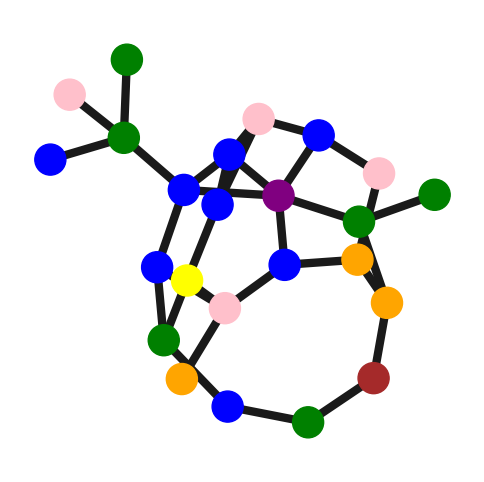

In [21]:
cls_1, cls_2, cls_3 = 1, 2, 7

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=False)

In [22]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

[6.81087111e-34 9.31772637e-19 1.29468672e-09 9.99998833e-01
 2.39145596e-44 1.75087842e-15 5.97201268e-25 1.16475307e-06]
[5.34227060e-33 3.08974745e-18 3.30572446e-09 1.43140058e-06
 3.66282429e-43 8.45701495e-15 2.77101224e-24 1.42891594e-06]


In [ ]:
base_res = trainer[cls_1, cls_2, cls_3].quantitative_baseline()
print(base_res["mean"])
print(base_res["std"])

In [221]:
f = open(f"logs/quantitative_mrsc9.txt", "a")
f.write(f'converged: True\n')
f.write(f'c1 = {cls_1}\n')
f.write(f'gnnboundary mean = {res["mean"][cls_1]} std = {res["std"][cls_1]}\n')
f.write(f'baseline mean = {base_res["mean"][cls_1]} std = {base_res["std"][cls_1]}\n')
f.write(f'c2 = {cls_2}\n')
f.write(f'gnnboundary mean = {res["mean"][cls_2]} std = {res["std"][cls_2]}\n')
f.write(f'baseline mean = {base_res["mean"][cls_2]} std = {base_res["std"][cls_2]}\n')
f.write(f'c3 = {cls_3}\n')
f.write(f'gnnboundary mean = {res["mean"][cls_3]} std = {res["std"][cls_3]}\n')
f.write(f'baseline mean = {base_res["mean"][cls_3]} std = {base_res["std"][cls_3]}\n\n')
f.close()

# 1, 4, 5

In [78]:
cls_1, cls_2, cls_3 = 1, 4, 5
trainer[cls_1, cls_2, cls_3] = GPUTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2, cls_3], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
    min_iteration=500
)

In [ ]:
cls_1, cls_2, cls_3 = 1, 4, 5
p_min = 0.266
p_max = 0.4
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_3: (p_min, p_max), cls_2: (p_min, p_max), cls_3: (p_min, p_max)},
    target_size=60,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=32
)

In [ ]:
cls_1, cls_2, cls_3 = 1, 4, 5

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=True)

In [ ]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

In [ ]:
base_res = trainer[cls_1, cls_2, cls_3].quantitative_baseline()